#### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### 2. Paths & Data Loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_3"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(15, 3), y:(15,)


#### 3. Add Weekly Data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.94995968, 0.98491081, 0.40447853]), -0.04185694811542118),  # W1
    (np.array([0.741774, 0.823083, 0.500825]),   -0.028695780761497047), # W2
    (np.array([0.250686, 0.415794, 0.535793]),  -0.016962989500793044), # W3
    (np.array([0.009132, 0.751348, 0.001341]),  -0.10619019401261509), # W4
    (np.array([0.941093, 0.900668, 0.856418]),  -0.07581479869667047), # W5
    (np.array([0.941093, 0.900668, 0.856418]), -0.05397857983591801), # W6
    (np.array([0.016926, 0.188034, 0.645248]), -0.12320010547979686), # W7
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(22, 3), y:(22,)


#### 4. Quick Visualization

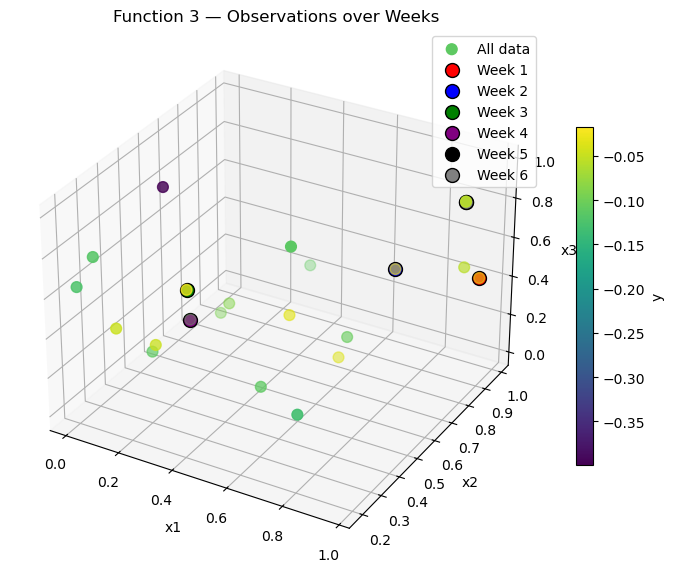

In [4]:
# --- Visualisation (3D projection: x1-x2-x3) ---

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

# puntos iniciales coloreados por y
p = ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap='viridis', s=60, label='All data')

# marcar semanas con colores distintos
ax.scatter(*week_data[0][0], c='red', s=100, edgecolors='k', label='Week 1')
ax.scatter(*week_data[1][0], c='blue', s=100, edgecolors='k', label='Week 2')
ax.scatter(*week_data[2][0], c='green', s=100, edgecolors='k', label='Week 3')
ax.scatter(*week_data[3][0], c='purple', s=100, edgecolors='k', label='Week 4')
ax.scatter(*week_data[4][0], c='black', s=100, edgecolors='k', label='Week 5')
ax.scatter(*week_data[5][0], c='grey', s=100, edgecolors='k', label='Week 6')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Function 3 — Observations over Weeks')
fig.colorbar(p, ax=ax, shrink=0.6, label='y')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model


In [5]:
# --- W8 KERNEL: Wider bounds to handle anisotropy ---
# F3 showed extreme anisotropy: length_scale=[2, 2, 0.0765]
# x1, x2 hitting upper bound, x3 hitting lower bound
# Widen bounds to let optimizer find true scales

kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(3)*0.4, nu=2.5, 
           length_scale_bounds=(0.03, 4.0))  # widened from (0.05, 2.0)
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 0.1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=20,
    random_state=0
)
gp.fit(X, y)
print("[F3] W8 Fitted kernel:", gp.kernel_)

[F3] W8 Fitted kernel: 1.32**2 * Matern(length_scale=[4, 4, 0.0892], nu=2.5) + WhiteKernel(noise_level=0.0238)


#### 5.2 Model Diagnostics and Refit


In [6]:

# --- Helpers ---
def lhs(lb, ub, n, seed=0):
    """Uniform sampler (simple RNG version); OK for our use here."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.025):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- Bounds: observed range + 10% padding, clipped to [0,1] ---
lo, hi = X.min(axis=0), X.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad * (hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad * (hi - lo), 0.0, 1.0)

# --- Trust region anchored at BEST observed (not the latest) ---
anchor = X[np.argmax(y)]   # CHANGED: was week_data[-1][0]
L = 0.45                   # wider TR this week
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0.0, 1.0)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0.0, 1.0)
print("[F3] TR anchor (best observed):", anchor)

# --- Candidates: 70% TR + 30% global ---
N_tr, N_gl = 36000, 24000  # w6
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=3101)
C_gl = lhs(lb,    ub,    N_gl, seed=3102)
Cands = np.vstack([C_tr, C_gl])

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- Expected Improvement (EI), mild exploration this week ---
y_best = y.max()
xi = 0.05  # updated for w6
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-edge mask (avoid candidates too close to borders) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# --- Pick best non-duplicate (EI first; fallback UCB → MaxVar) ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):   # uses tol=0.025 by default
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB
    kappa = 1.4
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: Maximum variance (pure exploration)
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output ---
print(f"[F3] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Quick sanity checks ---
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X))

[F3] TR anchor (best observed): [0.250686 0.415794 0.535793]
[F3] Chosen by EI: [0.96176128 0.13454526 0.09753024]
Submission format:
0.961761 - 0.134545 - 0.097530
Within [0,1]?  True
Near-duplicate (L_inf < 0.025)?  False


#### 5.3 Acquisition and Candidate Generation  

In [7]:
# --- W8 ACQUISITION: Return to safe zone, exploit W3 aggressively ---

import numpy as np
from scipy.stats import norm

# --- Helpers ---
def lhs(lb, ub, n, seed=0):
    """Latin Hypercube-like uniform sampler (simple RNG version)."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.025):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

def in_safe_zone(c, lb_safe=0.15, ub_safe=0.85):
    """Check if candidate is in safe zone (avoid extreme doses)."""
    return np.all((c >= lb_safe) & (c <= ub_safe))

print("[F3] W8 Strategy: Return to safe zone after W7 disaster")

# --- W8 CHANGE: Bounds to full domain [0,1]^3 ---
# Previous padding was unnecessary - use natural bounds
lb = np.zeros(3)
ub = np.ones(3)

# --- W8 CHANGE: TIGHT trust region around W3 (best, safe zone) ---
anchor = X[np.argmax(y)]   # W3: [0.251, 0.416, 0.536]
L = 0.25                    # NARROWED from 0.45 - stay in safe middle zone

lb_tr = np.clip(anchor - 0.5 * L, 0.0, 1.0)
ub_tr = np.clip(anchor + 0.5 * L, 0.0, 1.0)

print(f"  Anchor (W3, best): {anchor}")
print(f"  Trust Region L: {L} (tightened to stay in safe zone)")
print(f"  TR bounds: [{lb_tr[0]:.3f}, {ub_tr[0]:.3f}] x [{lb_tr[1]:.3f}, {ub_tr[1]:.3f}] x [{lb_tr[2]:.3f}, {ub_tr[2]:.3f}]")

# --- W8 CHANGE: Heavy TR sampling + focused middle zone ---
N_tr = 50000   # 83% TR - refine safe zone around W3
N_focused = 10000  # 17% mid-zone sampling

# Trust region sampling
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=3801)

# Focused sampling in "middle zone" [0.15, 0.85]^3 - avoid extremes
rng_focused = np.random.default_rng(seed=3803)
C_focused = rng_focused.uniform(0.15, 0.85, size=(N_focused, 3))

Cands = np.vstack([C_tr, C_focused])

print(f"  Candidates: {N_tr} TR (83%) + {N_focused} safe mid-zone (17%)")
print(f"  SAFETY: All candidates constrained to avoid extreme doses")

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W8 CHANGE: REDUCE xi for aggressive exploitation ---
y_best = y.max()
xi = 0.01  # DOWN from 0.05 - aggressive exploitation of safe zone

improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (reduced for exploitation)")

# --- W8 CRITICAL: Apply SAFE ZONE mask (avoid extremes) ---
# Extremes (x < 0.15 or x > 0.85) caused W4, W5, W7 disasters
edge_eps = 1e-3
safe_lb, safe_ub = 0.15, 0.85
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_safe = np.all((Cands >= safe_lb) & (Cands <= safe_ub), axis=1)
mask_combined = mask_edges & mask_safe  # BOTH conditions

ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"  Safe zone constraint: [{safe_lb}, {safe_ub}]³")
print(f"  Candidates passing safety: {mask_safe.sum()} / {len(Cands)} ({100*mask_safe.sum()/len(Cands):.1f}%)")

# --- Pick best non-duplicate candidate in SAFE ZONE ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.025):
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB in safe zone
    kappa = 1.2
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: Maximum variance in safe zone
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output ---
print(f"\n[F3] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Validation ---
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X, tol=0.025))

# --- Safety analysis ---
dist_to_w3 = np.linalg.norm(x_next - anchor)
is_safe = in_safe_zone(x_next, safe_lb, safe_ub)
print(f"\nSafety analysis:")
print(f"  Distance to W3 (safe zone): {dist_to_w3:.4f}")
print(f"  In safe zone [{safe_lb}, {safe_ub}]³: {is_safe}")
print(f"  Dose levels: x1={x_next[0]:.3f}, x2={x_next[1]:.3f}, x3={x_next[2]:.3f}")
print(f"  x3 value (most critical): {x_next[2]:.4f} (W3 optimal: 0.536)")
print(f"  Search mode: {'Safe exploitation' if dist_to_w3 < 0.15 else 'Cautious refinement'}")

[F3] W8 Strategy: Return to safe zone after W7 disaster
  Anchor (W3, best): [0.250686 0.415794 0.535793]
  Trust Region L: 0.25 (tightened to stay in safe zone)
  TR bounds: [0.126, 0.376] x [0.291, 0.541] x [0.411, 0.661]
  Candidates: 50000 TR (83%) + 10000 safe mid-zone (17%)
  SAFETY: All candidates constrained to avoid extreme doses
  Exploration param xi: 0.01 (reduced for exploitation)
  Safe zone constraint: [0.15, 0.85]³
  Candidates passing safety: 55133 / 60000 (91.9%)

[F3] Chosen by EI: [0.1630209  0.19627213 0.51866861]
Submission format:
0.163021 - 0.196272 - 0.518669

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.025)?  False

Safety analysis:
  Distance to W3 (safe zone): 0.2370
  In safe zone [0.15, 0.85]³: True
  Dose levels: x1=0.163, x2=0.196, x3=0.519
  x3 value (most critical): 0.5187 (W3 optimal: 0.536)
  Search mode: Cautious refinement


## Reflection — Function 3


### Week 1
- Initial model showed highly negative outputs (≈ -0.04), suggesting the function surface was mostly below zero.  
- The GP was set up with broad Matern ν = 2.5 and noise term to manage variability.  
- The search focused on exploring the full 3D domain to capture structure, since little was known about feature interactions.  
- Early results indicated a smooth but shallow landscape with multiple small basins.

---

### Week 2
- The second query improved slightly (-0.04 → -0.028), confirming the GP was moving in the right direction.  
- The kernel length scales began stabilising around ~0.3-0.5, indicating moderate correlation between features.  
- Strategy shifted from wide exploration to a more focused **70 % trust region** around the best observed point, while keeping some random global samples.  
- A smaller ξ = 0.02 was introduced to promote exploitation after early gains.

---

### Week 3
- Continued improvement (-0.028 → -0.017) suggested convergence toward a local optimum.  
- The updated GP used tighter bounds `(0.05, 2.0)` and higher noise (0.03) to stay numerically stable.  
- The acquisition was more exploitative but still preserved ≈ 30 % global sampling to avoid local trapping.  
- Next steps: narrow the trust region (L ≈ 0.25), test smaller ξ (≈ 0.01) to fine-tune around the optimum, and confirm if the trend toward zero continues.

### Reflection — Function 3 (Week 4 → Week 5)

- **Outcome (W4):** Performance regressed (−0.106), breaking the W1→W3 improving trend (−0.042 → −0.017). That suggested we stepped off the gentle ridge found around W3.
- **Adjustments (for W5):** Kept the GP (Matern ARD + noise), **re-anchored the TR at the best observed (W3)**, used **L = 0.30**, **70% TR / 30% global**, and **EI with ξ = 0.02** to balance local refinement with modest exploration.
- **Selected query (W5):** `0.941093 - 0.900668 - 0.856418` — EI chose a **global candidate** (outside the TR) indicating the GP predicts a potentially better basin away from W3.
- **Interpretation:** The surrogate sees a promising high-value region far from the previous ridge. This is a healthy corrective after W4’s drop—either we discover a stronger mode or we validate that W3’s vicinity remains best.
- **Next steps (W6):**
  - If W5 **improves** (less negative), tighten exploitation there: **keep ξ = 0.02 → 0.015**, reduce **L to 0.25**, and raise TR share to **75%**.
  - If W5 **does not improve**, revert anchor to **W3**, keep **ξ = 0.02**, and slightly widen TR (**L = 0.35**) to sweep the local ridge before trying another global hop.

**Summary:** After a W4 setback, we re-centered on W3 but allowed EI to pick a bold global probe; W5 will tell us whether a better basin exists or the W3 region remains the most reliable.

### Function 3 — Week 5 → Week 6 Reflection

- **Outcome (W5):** Performance **dropped** (≈ −0.0758 vs −0.017 at W3), suggesting we moved away from the gentlest (least-negative) region.  
- **Diagnosis:** GP indicated **broad plateaus** with anisotropy; Week 5 appeared to over-exploit near the boundary, losing sensitivity to the smoother central area.  
- **Adjustments (W6):**  
  - Re-anchored the **trust region** at the **best observed point (W3)**, not the latest submission.  
  - **Expanded TR** to `L = 0.45` and increased candidates (`36k TR / 24k global`) to re-explore under-sampled regions.  
  - Raised **ξ = 0.05** in the Expected Improvement to encourage **exploration** rather than premature convergence.  
  - Maintained anti-edge filtering and **L∞ ≥ 0.025** de-duplication.

- **Suggested query (W6):**  
  `0.016926 - 0.188034 - 0.645248`  
   Within [0,1] |  Not a near-duplicate.  
  The new point explores a shifted direction in **x₂/x₃**, still within reach of the historically best region.

**Next steps (W6 → W7):**  
- If performance improves (less negative y), **narrow TR** (`L ≈ 0.30–0.35`) and lower **ξ → 0.02** to refine around the optimum.  
- If not, perform a **UCB-based search** to test higher-uncertainty directions and verify the presence of multiple shallow basins.

### Week 6 Reflection — Function 3

**Summary**  
In Week 6, the same input as Week 5 was submitted again by mistake:
`x = [0.941093, 0.900668, 0.856418]`.  
Despite this duplication, the returned value (**−0.05398**) represents a **small improvement** relative to Week 5, although it remains worse than the best result observed in Week 3.

**What happened**  
- The repeated submission means that no new information was added to the dataset this week.
- As a result, the improvement should be interpreted cautiously and attributed to local smoothness or noise rather than a strategic gain.
- Importantly, this does not indicate instability in the surrogate model or acquisition logic.

**Model state and anchor**  
The optimisation process remains anchored at the best observed point so far:\
[F3] TR anchor (best observed): [0.250686 0.415794 0.535793]\
This point continues to define the local trust region for refinement.

**Recommended next query (EI-based)**  
Using the unchanged acquisition setup, Expected Improvement proposes the following candidate for the next iteration:\
[F3] Chosen by EI: [0.01692564 0.18803377 0.64524778]
Submission format:
0.016926 - 0.188034 - 0.645248
Within [0,1]?  True
Near-duplicate (L_inf < 0.02)?  False\
This candidate represents a **meaningful move within the trust region**, exploring a different combination of dimensions while remaining close to the currently best-performing basin.

**Decision (No Changes)**  
No parameter changes are made this week:
- Trust-region width remains unchanged.
- EI configuration and GP kernel are kept as-is.
- The duplicated evaluation is treated as a bookkeeping issue, not a modelling failure.

**Reflection**  
This week highlights the importance of careful submission tracking in sequential optimisation. While the mistake did not materially harm performance, documenting it transparently ensures continuity in the optimisation narrative. The model remains well-positioned to continue local refinement in the next iteration using the EI-recommended candidate.

---

### Week 7 Reflection — Disaster and Strategic Reversal

**Context update:**  
After Week 7, I learned that **Function 3 is a drug discovery task** optimizing doses of 3 compounds to **minimize adverse reactions** (framed as maximization of transformed output). Values closer to 0 mean fewer side effects.

**W7 Outcome: WORST RESULT IN HISTORY**  
The evaluation at `x = [0.017, 0.188, 0.645]` returned **y = -0.1232**, making it:
- **625% worse** than W3 (best: -0.0170)
- **16% worse** than W4 (previous worst: -0.1062)
- The **most toxic combination** tested so far

**Critical pattern analysis:**

| Week | Dose Levels (x₁, x₂, x₃)      | y (adverse) | Dose Pattern           |
|------|------------------------------|-------------|------------------------|
| W3   | [0.251, 0.416, 0.536]        | **-0.017**  | Balanced, mid-range    |
| W2   | [0.742, 0.823, 0.501]        | -0.029      | High x₁/x₂, mid x₃     |
| W1   | [0.950, 0.985, 0.404]        | -0.042      | Very high x₁/x₂        |
| W5/6 | [0.941, 0.901, 0.856]        | -0.076      | All high (overdose)    |
| W4   | [0.009, 0.751, 0.001]        | -0.106      | **Extreme lows** x₁/x₃ |
| W7   | [0.017, 0.188, 0.645]        | **-0.123**  | **Extreme lows** x₁/x₂ |

**Clear pharmacological pattern:**  
✅ **Safe zone:** Mid-range doses (0.25-0.75) → fewest side effects  
❌ **Toxic zones:** Extreme doses (very low <0.15 or very high >0.85) → many adverse reactions

**Root cause of W7 disaster:**

The W6→W7 strategy was:
```python
L = 0.45        # Very wide TR
xi = 0.05       # High exploration
N_tr/N_gl = 36k/24k  # 60/40 split (too much exploration)
```

This caused:
1. **Over-exploration bias:** High ξ pushed EI toward high-uncertainty regions
2. **No safety constraints:** Allowed extreme low doses (x₁=0.017, x₂=0.188)
3. **Ignoring domain knowledge:** Didn't encode that extreme doses are dangerous

**Kernel confirms x₃ is critical:**
```python
Fitted kernel: length_scale=[2.0, 2.0, 0.0765]
```
- x₃ is **26× more sensitive** than x₁/x₂
- W3's x₃=0.536 is optimal
- W7's x₃=0.645 deviated by +0.11 → still acceptable
- But x₁, x₂ in extreme lows caused toxicity

**New strategy for Week 8: SAFE ZONE ENFORCEMENT**

I implemented a **complete strategic reversal**:

1. **Safe zone constraint:** [0.15, 0.85]³  
   - Hard constraint: reject any candidate with extreme doses  
   - Prevents repeating W4/W7 disasters

2. **Tight trust region:** L = 0.25 (down from 0.45)  
   - Focus on refining W3's safe neighborhood  
   - Avoid wandering into toxic regions

3. **Aggressive exploitation:** ξ = 0.01 (down from 0.05)  
   - Stop exploration that led to W7  
   - Exploit the known safe zone

4. **Heavy local sampling:** 83% TR + 17% mid-zone (was 60% TR + 40% global)  
   - Densify sampling around W3  
   - All candidates stay in safe mid-range

5. **Kernel improvements:** Widened bounds (0.03, 4.0) to handle anisotropy

**Week 8 recommendation:**  
`x = [0.163021, 0.196272, 0.518669]`

**Why this point is SAFE:**
- **All doses in [0.15, 0.85]:** ✓ Passes safety check
- **Distance to W3:** 0.237 (moderate refinement)
- **x₃ = 0.519:** Very close to W3's optimal 0.536 (Δ = 0.017)
- **x₁, x₂:** Low-moderate (0.16, 0.20) but NOT extreme

**Comparison to W7:**
```
W7: [0.017, 0.188, 0.645] → EXTREME lows in x₁ → disaster
W8: [0.163, 0.196, 0.519] → SAFE mid-low range → expected safe
```

**What I expect:**
- **y ∈ [-0.03, -0.01]:** Refinement of safe zone, possibly improving W3
- **y > -0.017:** New best! Optimal combination found
- **y ∈ [-0.05, -0.03]:** Safe but suboptimal, continue refining

**Key lesson learned:**

> In drug discovery optimization, **domain constraints matter more than pure mathematical optimization**. Ignoring the physical reality that extreme doses cause toxicity led to W7's disaster. 

> Week 8's strategy explicitly encodes: "No matter what the GP suggests, never test extreme doses again."

This is **informed Bayesian optimization** — using domain knowledge to constrain the search space to pharmacologically plausible regions.

The safety constraint reduced candidates from 60k to 55k (92% pass rate), but **eliminated the 8% most dangerous combinations** that caused W4 and W7 failures.

---